This project uses the data from the walkthrough here: https://www.youtube.com/watch?v=Nx5cuJA_lIs and the data from Fear&Hunger wiki to understand what each item does and close up the missing data, such as the weapons War Scythe and Sergal Spear, which exist in the game but wasn't seen in the walkthrough. below are the values inside out .csv files

| Column | Description |
|--------|-------------|
| Name | Weapon name |
| ATK | Attack value |
| #AltWeaponsLowerOrEqual | Number of weapons with lower or equal ATK |
| WeaponNumber | how many copies of this specific weapon can be obtained, calculated by RNG, guaranteed and enemy drops|
| AcquisitionType | `Guaranteed`, `RNG`, or `Enemy Drop` (one weapon can have multiple ways of obtaining it) |
| NumEnemiesDrop | Number of enemies that drop this weapon |
| EnemyPopulationDrop     | Total number of individual enemies that can drop this weapon |
| NumRNGSpots | Number of RNG locations it can be found / totalRNGspots |
| NumGuaranteedSpots | Number of fixed spots it can be obtained from |
| UsefulnessScore | Calculated as: `#AltWeaponsLowerOrEqual + (NumEnemiesDrop) + (NumGuaranteedSpots + (NumRNGSpots)`|

### Status Effects Dataset (`status_effects.csv`)
| Column | Description |
|--------|-------------|
| Name | Status effect name |
| NumEnemiesToGet | Total number of enemies that apply it |
| NumCures | Number of known cures for the status effect |
| TotalCureCount | Calculated for each status as (total RNG spots/ item count) + guaranteed spots |
| Curability | 1 if there is no known cure, 0 otherwise |
| DangerLevel | Calculated as: `(NumWaysToGet − CureAvailabilityScore)+(Uncurable * 20)` |

point of this project and all of these data is to conduct data analysis to find an answer for the questions below:

RQ1: Is ATK related to a weapons usefulness?

H₀: Weapon ATK value is not correlated with usefulness.

Hₐ: Weapons with higher ATK are significantly more useful.

RQ2: Does a weapon's frequency affects its usefulness?

H₀: Weapon acquisition method is not correlated with usefulness.

Hₐ: Weapons with more acquisition paths are significantly more useful.


RQ3: Do status effects get more dangerous with their frequency?

H₀: Frequancy of a status effect does not make it more dangerous.

Hₐ: Status effects with higher frequency of application are more dangerous.

RQ4: Do status effects get more dangerous if they have no cure?

H₀: Curability of a status effect does not make it more dangerous.

Hₐ: Status effects with fewer cures are more dangerous.


What I have taken help from AI: Transposing and rearranging my .csv files to be readable, defining custom color palettes for my graphs


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Mounted at /content/drive


This code below is to tidy up my StatusEffectsAndCures.csv files to have a regural .csv format.


In [ ]:
url_prefix = "https://raw.githubusercontent.com/HCanCaglar/DSA210_Fear_and_Hunger/main"


# Load data
status_effects_df = pd.read_csv(f"{url_prefix}/StatusEffectsAndCures.csv", sep=';')

# Transpose it correctly
status_effects_df.set_index('Name', inplace=True)
status_effects_df = status_effects_df.T
status_effects_df = status_effects_df.reset_index()
status_effects_df.rename(columns={'index': 'Name'}, inplace=True)

# Convert necessary columns to float
numeric_cols = ['NumEnemiesToGet', 'NumCures', 'TotalCureCount', 'Curability', 'DangerLevel']
for col in numeric_cols:
    if col in status_effects_df.columns:
        status_effects_df[col] = status_effects_df[col].astype(str).str.replace(',', '.').astype(float)


stats_df = status_effects_df.describe()



We have to make some assumptions on the data we have collected to interpret tests on them: We will get all the necessary crafting recipies, all creates only spawn cure items, all of them have equal chance of spawning and we have lost all the chest coinflips.This is because we dont know the RNG chance of all the items in the game and we cannot assume how many items we will get except the guaranteed item spots. Second assumption in that we will counts all the blue herbs and blue vials available to be used in crafting for staus curing, since we cannot know how much healing a person may need and we are simply searching "how easy can we cure a status effect. By the data we have collected, 321 spawning chances both creates and chests, we assumed that among the 10 items, we will get 32,1 of each then added the guaranteed amount of items we can find in the game.



In [ ]:
print("\nStatus Effects Dataset Statistics:")

# Exclude Name from the output
stats_string = stats_df.to_string(index_names=False)
print(stats_string)



Status Effects Dataset Statistics:
       NumEnemiesToGet   NumCures  TotalCureCount  Curability  DangerLevel
count        15.000000  15.000000       15.000000   15.000000    15.000000
mean         19.200000   0.666667       25.793333    0.533333     4.813333
std          25.086137   0.816497       34.428694    0.516398    40.471540
min           2.000000   0.000000        0.000000    0.000000   -93.200000
25%           3.500000   0.000000        0.000000    0.000000    -3.150000
50%           6.000000   0.000000        0.000000    1.000000    23.000000
75%          21.500000   1.000000       38.100000    1.000000    26.000000
max          85.000000   2.000000       97.200000    1.000000    37.000000


According to the data above, for all the 15 status effects, we can start making some assumptions.

1) Status effects arent equally applied. some of them are extremely common and some are very rare

2) Not all status effects have a cure, since mean for NumCures is less than 0

3) Curability being mean 0.53 tells us that more half of these status effects have a cure. we can use this because Curability has either 0 or 1 value for each status effect

4) Danger Level values cannot be directly commented on by their mean because of extremely high extreme + and - values causing a very high standard deviation. but we can categorize each staus effect's danger level by their interquartile values and where they fall into.

In [ ]:
# Number of enemies vs danger level
enemy_corr, enemy_pval = stats.pearsonr(status_effects_df['NumEnemiesToGet'], status_effects_df['DangerLevel'])
print(f"\nCorrelation between NumEnemiesToGet and DangerLevel: {enemy_corr:.3f}, p-value: {enemy_pval:.3f}")

# Total cure count vs danger level
cure_corr, cure_pval = stats.pearsonr(status_effects_df['TotalCureCount'], status_effects_df['DangerLevel'])
print(f"Correlation between TotalCureCount and DangerLevel: {cure_corr:.3f}, p-value: {cure_pval:.4f}")

# T-test: Curability vs danger level
curable = status_effects_df[status_effects_df['Curability'] == 0]['DangerLevel']
uncurable = status_effects_df[status_effects_df['Curability'] == 1]['DangerLevel']
t_stat, p_val = stats.ttest_ind(curable, uncurable, equal_var=False)
print(f"T-test for curability effect on danger level: t={t_stat:.3f}, p-value={p_val:.3f}")



Correlation between NumEnemiesToGet and DangerLevel: 0.206, p-value: 0.461
Correlation between TotalCureCount and DangerLevel: -0.834, p-value: 0.0001
T-test for curability effect on danger level: t=-2.565, p-value=0.042


Our hypothesis tests for status effects followed as:

RQ3: Do status effects get more dangerous with their frequency?

H₀: Frequancy of a status effect does not make it more dangerous.

Hₐ: Status effects with higher frequency of application are more dangerous.

RQ4: Do status effects get more dangerous if they have no cure?

H₀: Curability of a status effect does not make it more dangerous.

Hₐ: Status effects with fewer cures are more dangerous.


when we took alpha as 0.05 for our H₀, we will come to conclusions of:

1)0.461 > 0.05 tells us that we cannot come to the conclusion that if the number of enemies applying a specific status effect is high, the status effect will be more dangerous.

2) 0.0001 < 0.005 tells us that if a status effect has a lower number of cures available, it will have a higher danger level

3)0.042 < 0.05 tells us that on average, uncurable effects are more dangerous

based on these data, we reject H₀ for RQ3 but fail to reject H₀ for RQ4



In [ ]:
custom_colors = {
    "Confused": "#d3d3d3",              # light grey
    "Fracture": "#e5e4e2",              # bone white/grey
    "Bleeding": "#ff0000",              # red
    "Poisoned": "#cba0ff",              # lighter purple
    "toxic": "#800080",                 # darker purple
    "inefcted arm": "#ccffcc",          # very light green
    "infected leg": "#006400",          # dark green
    "Blindness": "#000000",             # black
    "Critical State": "#ffa500",        # orange
    "Burning": "#ffff00",               # yellow
    "Paralyzed": "#0000ff",             # blue
    "Parasites": "#d2b48c",             # tan
    "Brain flower": "#b8860b",          # dark yellow
    "Severe anal bleedding": "#8b0000", # dark red
    "Curse": "#8b4513",                 # brown
}


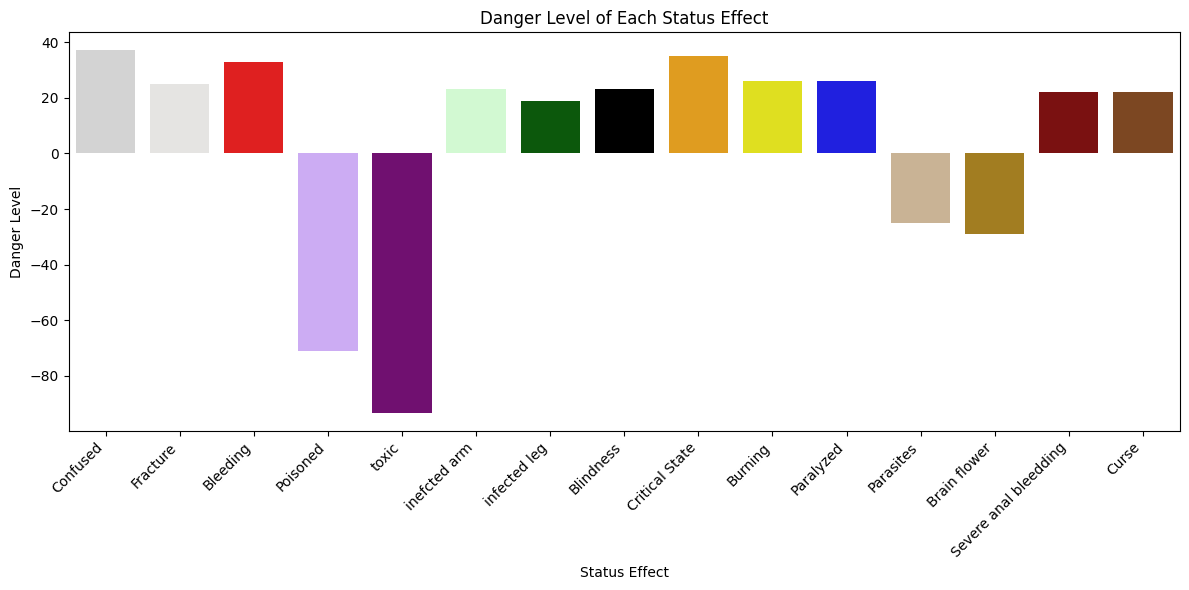

In [ ]:
plt.figure(figsize=(12, 6))
colors = [custom_colors[name] for name in status_effects_df['Name']]
sns.barplot(x='Name', y='DangerLevel', data=status_effects_df, palette=colors, hue='Name', legend=False)
plt.title('Danger Level of Each Status Effect')
plt.xlabel('Status Effect')
plt.ylabel('Danger Level')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
display(plt.gcf())
plt.close()


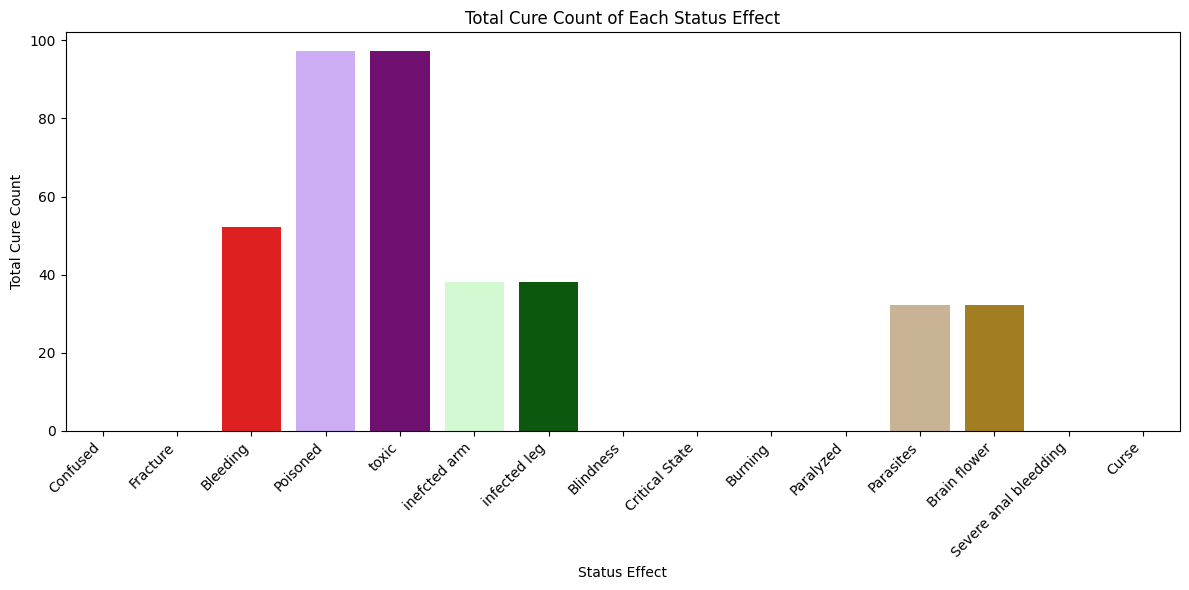

In [ ]:
plt.figure(figsize=(12, 6))
colors = [custom_colors[name] for name in status_effects_df['Name']]
sns.barplot(x='Name', y='TotalCureCount', data=status_effects_df, palette=colors, hue='Name', legend=False)
plt.title('Total Cure Count of Each Status Effect')
plt.xlabel('Status Effect')
plt.ylabel('Total Cure Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
display(plt.gcf())
plt.close()


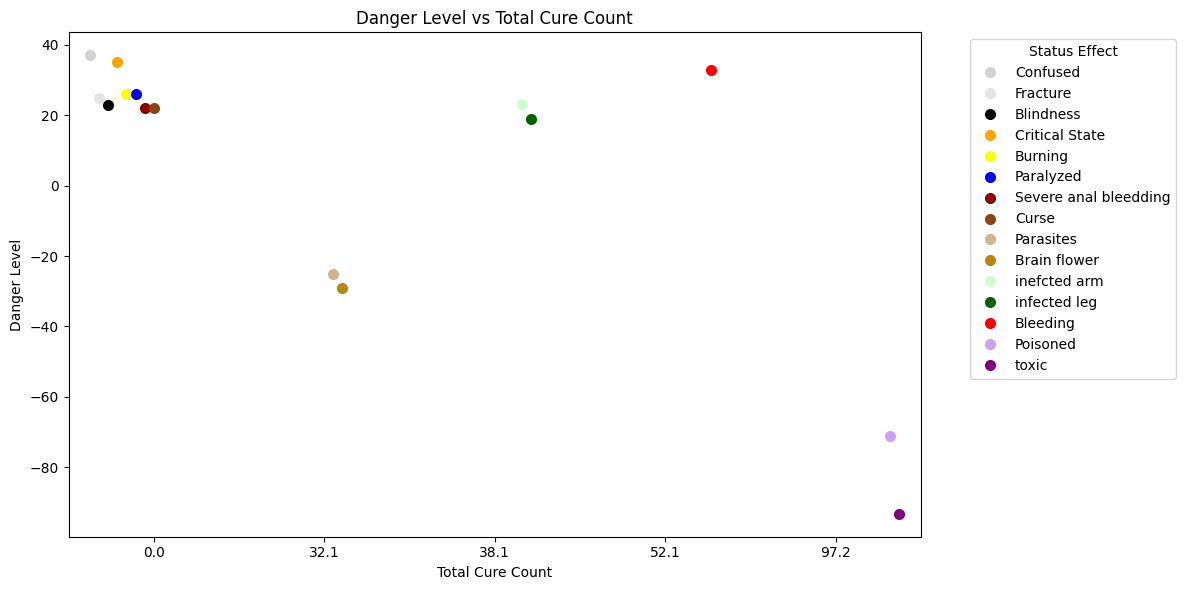

In [ ]:
plt.figure(figsize=(12, 6))
sns.swarmplot(
    data=status_effects_df,
    x='TotalCureCount',
    y='DangerLevel',
    hue='Name',
    palette=custom_colors,
    size=8,
    dodge=True
)

plt.legend(title='Status Effect', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Danger Level vs Total Cure Count')
plt.xlabel('Total Cure Count')
plt.ylabel('Danger Level')
plt.tight_layout()
display(plt.gcf())
plt.close()


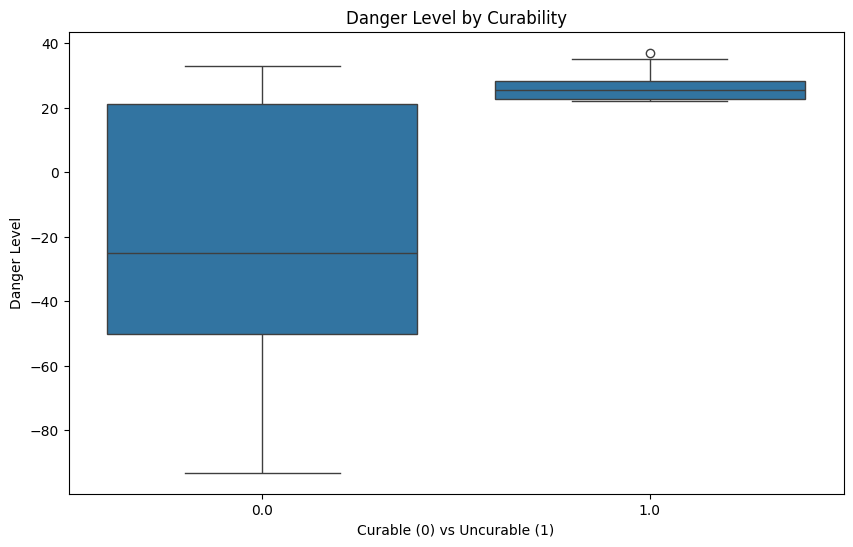

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Curability', y='DangerLevel', data=status_effects_df)
plt.title('Danger Level by Curability')
plt.xlabel('Curable (0) vs Uncurable (1)')
plt.ylabel('Danger Level')
display(plt.gcf())
plt.close()


Based on the box graph comparios above, we can say that curable status effect greately vary in danger levels. some of the curable effects are less dangerous than the rest and we can say that just because a status effect is curable, that doesnt mean it has to be safe to handle / non-dangerous. However uncurable status effects are very intact and inside a very clustered danger level values. this can tell us that uncurable status effects are usually dangerous.

Unlike status effects, we dont have to make too many assumptions for RNG context of finding weapons. we have total of 4 weapon racks and 24 chests. we know which weapons can be obtained by RNG and which we cannot. We have to assume that we won all the chest coin flips and we can obtain only weapons from the chests and from that assumption we can obtain 2.8 copies the weapons that have RNG attribute. also by calculating the RNG, guarantee and enemy drop values we can say that in total we can obtain 65.6 weapons in total. We have no missing data, despite the walkthrough not obtaining every weapon we could find how the other ones are obtained via Wiki page of F&H

In [ ]:
# Transpose Weapons Data
weapons_df = pd.read_csv(f"{url_prefix}/Weapons.csv", sep=';', index_col=0)
weapons_df.columns = weapons_df.columns.str.strip()  # Clean column names

# Transpose and rename
weapons_df = weapons_df.T.reset_index().rename(columns={'index': 'Weapon'})

# Convert all relevant numeric columns (handle commas)
numeric_columns = ['ATK','AltWeaponsLowerOrEqual', 'WeaponNumber', 'NumEnemiesDrop', 'EnemyPopulationDrop',
                  'NumRNGSpots', 'NumGuaranteedSpots', 'UsefulnessScore']

for col in numeric_columns:
    if col in weapons_df.columns:
        weapons_df[col] = weapons_df[col].astype(str).str.replace(',', '.').astype(float)


print("\nDescriptive statistics:")

# Set display options to see all data in 1 list
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

stats_df = weapons_df[numeric_columns].describe()

# remove Name from the output
stats_string = stats_df.to_string(index_names=False)

print(stats_string)



Descriptive statistics:
              ATK  AltWeaponsLowerOrEqual  WeaponNumber  NumEnemiesDrop  EnemyPopulationDrop  NumRNGSpots  NumGuaranteedSpots  UsefulnessScore
count   22.000000               22.000000     22.000000       22.000000            22.000000    22.000000           22.000000        22.000000
mean    47.227273               34.990909      2.981818        1.090909             0.590909     1.527273            0.454545        37.927273
std     31.461135               22.050373      3.312837        2.974640             1.140555     1.427012            0.595801        21.171188
min      5.000000                0.000000      1.000000        0.000000             0.000000     0.000000            0.000000         1.000000
25%     27.750000               10.000000      1.000000        0.000000             0.000000     0.000000            0.000000        16.300000
50%     37.500000               40.500000      2.800000        0.000000             0.000000     2.800000            

According to the data above,Among the 22 weapons, it is safe to say that:

1) Most of the weapons exist singularly. Meaning that they are either not dropped by enemies nor found in rng spots.

2) Most of the dropped weapons come from different types of enemies.

3) there exists 1 weapons that has the highest attack, and it may have the highest UsefulnessScore or there exists a weapons with lower attack but more copies

In [ ]:

atk_corr, atk_pval = stats.pearsonr(weapons_df['ATK'], weapons_df['UsefulnessScore'])
print(f"\nCorrelation between ATK and UsefulnessScore: {atk_corr:.3f}, p-value: {atk_pval:.3f}")

wn_corr, wn_pval = stats.pearsonr(weapons_df['WeaponNumber'], weapons_df['UsefulnessScore'])
print(f"Correlation between WeaponNumber and UsefulnessScore: {wn_corr:.3f}, p-value: {wn_pval:.3f}")

# T-Test on 2 groups: below vs above median of ATK
median_atk = weapons_df['ATK'].median()
group1 = weapons_df[weapons_df['ATK'] <= median_atk]['UsefulnessScore']
group2 = weapons_df[weapons_df['ATK'] > median_atk]['UsefulnessScore']
t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
print(f"T-test (low vs high ATK) on UsefulnessScore: t={t_stat:.3f}, p-value={p_val:.3f}")


Correlation between ATK and UsefulnessScore: 0.885, p-value: 0.000
Correlation between WeaponNumber and UsefulnessScore: -0.180, p-value: 0.423
T-test (low vs high ATK) on UsefulnessScore: t=-7.382, p-value=0.000


Our research questions followed as:

RQ1: Is ATK related to a weapons usefulness?

H₀: Weapon ATK value is not correlated with usefulness.

Hₐ: Weapons with higher ATK are significantly more useful.

RQ2: Does a weapon's frequency affects its usefulness?

H₀: Weapon acquisition method is not correlated with usefulness.

Hₐ: Weapons with more acquisition paths are significantly more useful.


1) ATK vs Usefulness score's pearson coef is very close to 1, telling us there is a strong positive relationship between ATK and usefulness score. 0.000 < 0.05 tells us that this is also statistically significant and not by random chance, meaning that as ATK increases UsefulnessScore increases as well

2)WeaponNumber vs UsefulnessScore's pearson Coef is -0.180, telling us that it is weak and negative correlation between weapon number and usefulness score, usually if a weapon is found more frequently its usefulness score will not be higher but this value is too low/very close to 0. And 0.423 > 0.05 tells us that frequency of obtaining a weapon doesn't strongly affect overall UsefulnessScore

3) Two sample T-test's p value 0.000 < 0.05. this less us that there is a strong evidence that higher ATK results in higher UsefulnessScore.

Based on these conclusions, we reject H₀ for RQ2 but fail to reject H₀ for RQ1

In [ ]:
custom_palette = {
    'Short Sword': 'saddlebrown',         # dark brown
    'Long Sword': 'burlywood',            # light brown
    'Iron spear': 'black',
    'Iron mace': 'gray',
    'short bow': 'tan',
    'scimitar': 'orange',
    'dagger': 'lightgray',
    'meat cleaver': '#bfa200',            # dark yellow
    'morning star': '#c04000',            # blood orange
    'bone shears': 'darkred',
    'axe': '#ff6666',                     # light red
    'shark teeth': 'lightskyblue',
    'ritual spear': 'navy',               # dark blue
    'war scythe': 'indigo',               # dark purple
    'claymore': 'pink',
    'eastern sword': 'green',
    'purified eastern sword': 'darkgreen',
    'Blue sin': '#0096FF',                # bluebird
    'skeletal arm': 'gold',
    'crude sword': '#e30b5d',             # raspberry red
    'sergal spear': '#580F41',            # eggplant purple
    'miasma': '#C8A2C8'                   # lilac
}


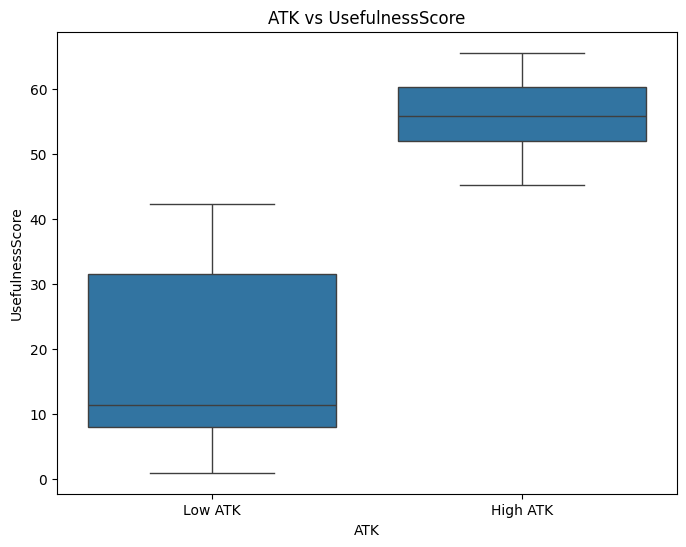

In [ ]:

weapons_df['ATK'] = weapons_df['ATK'].apply(lambda x: 'Low ATK' if x <= median_atk else 'High ATK')

plt.figure(figsize=(8, 6))
sns.boxplot(x='ATK', y='UsefulnessScore', data=weapons_df)
plt.title('ATK vs UsefulnessScore')
plt.show()


Box graphs above supports our claim to reject H₀, telling us that all weapons with Lower ATK actually has less UsefulnessScore compared to weapons with higher ATK.

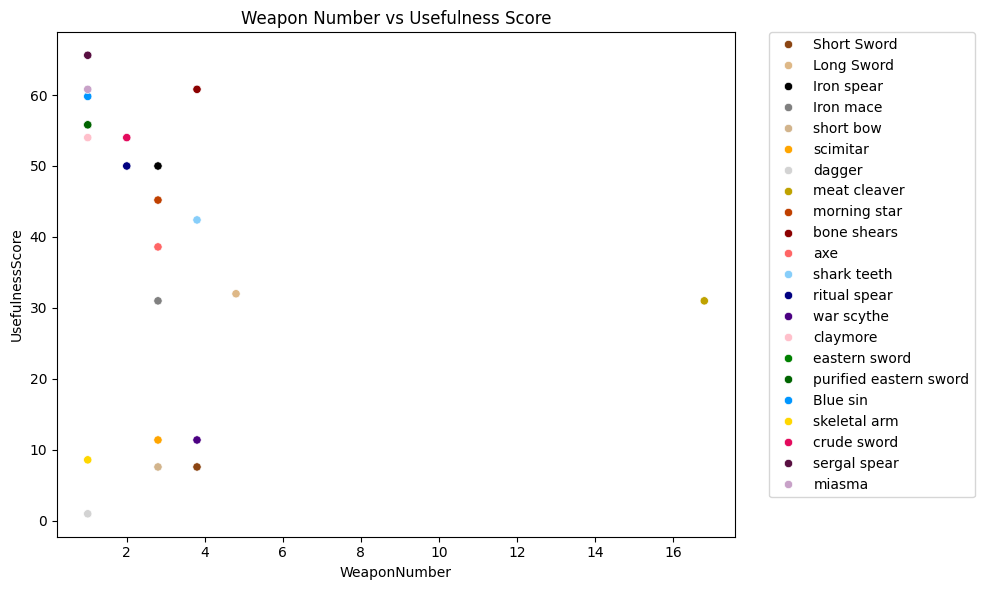

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WeaponNumber', y='UsefulnessScore', data=weapons_df, hue='Weapon', palette=custom_palette)
plt.title('Weapon Number vs Usefulness Score')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


This Scatter Plot helps us understand that most weapons with lower frequency in the game actually have higher UsefulnessScore